In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [34]:
def split_data(df, choose):
  if choose == 1: # 7:2:1
    train_size = int(len(df) * 0.7)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]

  elif choose == 2: # 5:3:2
    train_size = int(len(df) * 0.5)
    test_size = int(len(df) * 0.3)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]

  elif choose == 3: # 6:2:2
    train_size = int(len(df) * 0.6)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]


  print("Train: ", train_size)
  print("Test: ", test_size)
  print("Val: ", val_size)

  return train_data, test_data, val_data


In [35]:
df = pd.read_csv('/content/drive/MyDrive/IS403.N22/Project/dataset/TSLA_Stock.csv',usecols=['Date', 'Price'], parse_dates=['Date'], index_col='Date')
df.head()

,Price
Date,
2017-12-01,20.44
2017-12-04,20.35
2017-12-05,20.25
2017-12-06,20.88
2017-12-07,20.75


In [36]:

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

train_data, test_data, val_data = split_data(scaled_data , 1)

Train:  974
Test:  278
Val:  140


In [37]:
n_steps = 10
n_features = 1

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Tạo input sequences cho training, validation, và testing
X_train, y_train = create_sequences(train_data, n_steps)
X_val, y_val = create_sequences(val_data, n_steps)
X_test, y_test = create_sequences(test_data, n_steps)

In [38]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

#### CNN

In [42]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

In [ ]:

model.summary()

In [44]:
model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))#, metrics=[MeanAbsolutePercentageError()])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
31/31 [==============================] - 1s 8ms/step - loss: 0.0118 - val_loss: 0.0047
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 9.7505e-04 - val_loss: 0.0047
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 9.9089e-04 - val_loss: 0.0037
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 7.5209e-04 - val_loss: 0.0039
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 8.3370e-04 - val_loss: 0.0038
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 7.3257e-04 - val_loss: 0.0041
Epoch 9/100
31/31 [==============================] - 0s 7ms/step - loss: 9.3294e-04 - val_loss: 0.0036
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 7.9100e-04 

##### GridSearch TCN

In [45]:
def build_cnn_model(activation):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation=activation, input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(100, activation=activation))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))

    return model

In [46]:
cnn_model = KerasRegressor(build_fn=build_cnn_model, verbose=0)
param_grid = {'activation': ['relu', 'tanh', 'sigmoid','LeakyReLU']}

grid_tcn = GridSearchCV(estimator=cnn_model, param_grid=param_grid, cv=3, error_score='raise')
grid_tcn_result = grid_tcn.fit(X_train, y_train)

best_activation = grid_tcn_result.best_params_['activation']
print(f'Best activation: {best_activation}')

<ipython-input-46-52457029ca25>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cnn_model = KerasRegressor(build_fn=build_cnn_model, verbose=0)


Best activation: tanh


In [ ]:
model_best = build_cnn_model(best_activation)
history = model_best.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

##### Evaluation model

In [48]:
def evaluation_model(model):
  # evaluate trên tập test
  loss_test = model.evaluate(X_test, y_test, verbose=0)
  print("loss_test: ", loss_test)

  # evaluate trên tập val
  loss_val = model.evaluate(X_val, y_val, verbose=0)
  print("loss_val: ", loss_val)

In [49]:
evaluation_model(model)

loss_test:  0.0026441372465342283
loss_val:  0.00125078484416008


In [50]:
evaluation_model(model_best)

loss_test:  0.002239691326394677
loss_val:  0.0008139671990647912


In [51]:
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
y_val = scaler.inverse_transform(y_val)

In [52]:
def mae_rmse_mape(true, predict):
  mae = mean_absolute_error(true, predict)
  rmse = np.sqrt(mean_squared_error(true, predict))
  mape = mean_absolute_percentage_error(true, predict)

  return mae, rmse, mape

In [53]:
def predict_future(model, number_days):
  last_sequence = X_val[-1:]
  predicted_values = []
  for _ in range(number_days):
    next_value = model.predict(last_sequence)
    predicted_values.append(next_value[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], [next_value], axis=1)
  predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
  predicted_values = np.array(predicted_values).reshape(-1, 1)
  return predicted_values

In [54]:
def metrics(model):
  y_pred_test = model.predict(X_test)
  y_pred_val = model.predict(X_val)

  y_pred_test = scaler.inverse_transform(y_pred_test)
  y_pred_val = scaler.inverse_transform(y_pred_val)


  mae_test, rmse_test, mape_test = mae_rmse_mape(y_test, y_pred_test)
  mae_val, rmse_val, mape_val = mae_rmse_mape(y_val, y_pred_val)
# mae_test, rmse_test, mape_test = mae_rmse_mape(y_test, model.predict(X_test))
# mae_val, rmse_val, mape_val = mae_rmse_mape(y_val, model.predict(X_val))

  print('MAE of Test: ', mae_test)
  print('RMSE of Test: ', rmse_test)
  print('MAPE of Test: ', mape_test)
  print('------------------------')
  print('MAE of Validation: ', mae_val)
  print('RMSE of Validation: ', rmse_val)
  print('MAPE of Validation: ', mape_val)

In [55]:
metrics(model)

5/5 [==============================] - 0s 2ms/step
MAE of Test:  16.564655763996182
RMSE of Test:  20.467681724543496
MAPE of Test:  0.059050908032207056
------------------------
MAE of Validation:  11.3992233581543
RMSE of Validation:  14.077257388540854
MAPE of Validation:  0.06975763888783093


In [56]:
metrics(model_best)

5/5 [==============================] - 0s 2ms/step
MAE of Test:  14.554525451660156
RMSE of Test:  18.837394607038018
MAPE of Test:  0.049131300860906946
------------------------
MAE of Validation:  8.990288423978368
RMSE of Validation:  11.356126737250156
MAPE of Validation:  0.052220599019422734


##### Visualization TCN

In [57]:
number_days = 30

# train_actual = scaler.inverse_transform(train_data.reshape(-1, 1))
# val_actual = scaler.inverse_transform(val_data.reshape(-1, 1))
# test_actual = scaler.inverse_transform(test_data.reshape(-1, 1))

# val_predictions = scaler.inverse_transform(model.predict(X_val))
# test_predictions = scaler.inverse_transform(model.predict(X_test))



# train_actual = train_data.reshape(-1, 1)
# val_actual = val_data.reshape(-1, 1)
# test_actual = test_data.reshape(-1, 1)

# val_predictions = model.predict(X_val)
# test_predictions = model.predict(X_test)

In [62]:
def visualization(model):
  y_pred_test = model.predict(X_test)
  y_pred_val = model.predict(X_val)

  y_pred_test = scaler.inverse_transform(y_pred_test)
  y_pred_val = scaler.inverse_transform(y_pred_val)

  plt.figure(figsize=(12,6))

  plt.plot(range(len(y_train)), y_train, label='Train')

  plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test')
  plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred_test, label='Test Prediction')

  plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_val, label='Validation')
  plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_pred_val, label='Validation Prediction')

  # predicted_values = predict_future(model, number_days)
  # plt.plot(range(len(y_train) + len(y_test) + len(y_val), len(y_train) + len(y_test) + len(y_val) + number_days), predicted_values, label='30days_Next')

  plt.legend()
  plt.show()

In [ ]:
visualization(model)

5/5 [==============================] - 0s 6ms/step


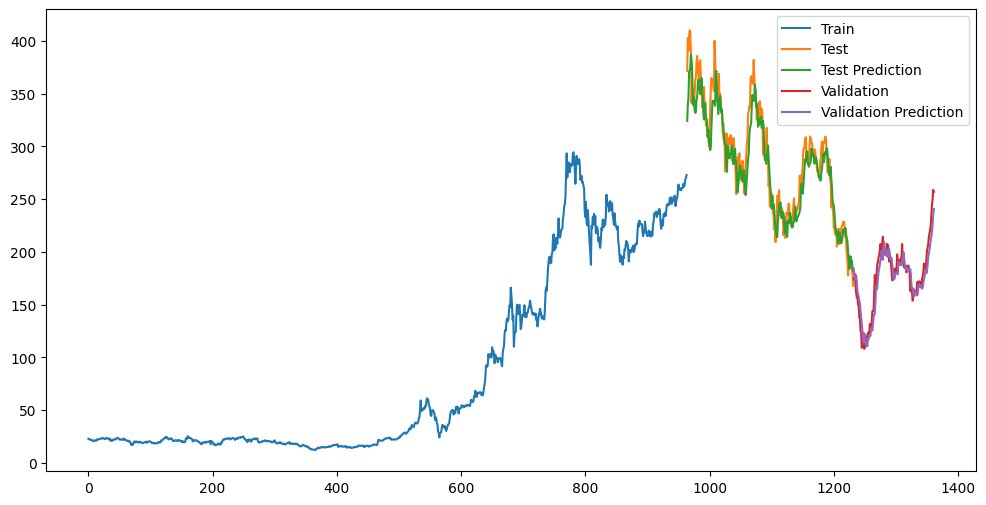

In [63]:
visualization(model_best)

In [61]:

# dates = df.index

# # Plot the training data
# plt.figure(figsize=(12, 8))
# plt.plot(dates[:len(train_actual)], train_actual, label='Train')

# # Plot the validation data
# test_offset = len(train_actual)
# plt.plot(dates[test_offset:test_offset + len(test_actual)], test_actual, label='Test')
# plt.plot(dates[test_offset:test_offset + len(test_predictions)], test_predictions, label='Test Predictions')

# # Plot the testing data
# val_offset = test_offset + len(test_actual)
# plt.plot(dates[val_offset:val_offset + len(val_actual)], val_actual, label='Validation')
# plt.plot(dates[val_offset:val_offset + len(val_predictions)], val_predictions, label='Validation Predictions')

# predicted_values = predict_future(model, number_days)
# next30days_offset = pd.date_range(start=dates[-1], periods=31, closed='right')
# plt.plot(next30days_offset, predicted_values, label='30 next days')

# # Rotate x-axis labels for better visibility
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()
